In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

/home/eurismar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/eurismar/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [12]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3000, batch_size=32, sample_interval=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/home/eurismar/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.666342, acc.: 53.12%] [G loss: 0.599773]
1 [D loss: 0.374948, acc.: 75.00%] [G loss: 0.614589]
2 [D loss: 0.370435, acc.: 68.75%] [G loss: 0.602094]
3 [D loss: 0.345613, acc.: 75.00%] [G loss: 0.736241]
4 [D loss: 0.334392, acc.: 81.25%] [G loss: 0.838205]
5 [D loss: 0.281294, acc.: 96.88%] [G loss: 1.047553]
6 [D loss: 0.254512, acc.: 93.75%] [G loss: 1.151165]
7 [D loss: 0.224041, acc.: 100.00%] [G loss: 1.442644]
8 [D loss: 0.184615, acc.: 100.00%] [G loss: 1.591441]
9 [D loss: 0.127401, acc.: 100.00%] [G loss: 1.675894]
10 [D loss: 0.138125, acc.: 100.00%] [G loss: 2.017320]
11 [D loss: 0.082216, acc.: 100.00%] [G loss: 2.172363]
12 [D loss: 0.088468, acc.: 100.00%] [G loss: 2.167939]
13 [D loss: 0.076171, acc.: 100.00%] [G loss: 2.275750]
14 [D loss: 0.076061, acc.: 100.00%] [G loss: 2.429265]
15 [D loss: 0.067605, acc.: 100.00%] [G loss: 2.413362]
16 [D loss: 0.067867, acc.: 100.00%] [G loss: 2.590569]
17 [D loss: 0.054933, acc.: 100.00%] [G loss: 2.788881]
18 [D los

149 [D loss: 0.116191, acc.: 93.75%] [G loss: 4.120520]
150 [D loss: 0.176938, acc.: 90.62%] [G loss: 3.539700]
151 [D loss: 0.122835, acc.: 96.88%] [G loss: 3.993671]
152 [D loss: 0.179725, acc.: 96.88%] [G loss: 3.687803]
153 [D loss: 0.114610, acc.: 90.62%] [G loss: 3.761090]
154 [D loss: 0.173377, acc.: 96.88%] [G loss: 3.668624]
155 [D loss: 0.055333, acc.: 100.00%] [G loss: 3.710798]
156 [D loss: 0.409288, acc.: 84.38%] [G loss: 3.251846]
157 [D loss: 0.097797, acc.: 93.75%] [G loss: 4.236914]
158 [D loss: 0.081725, acc.: 96.88%] [G loss: 3.327410]
159 [D loss: 0.175472, acc.: 90.62%] [G loss: 4.438991]
160 [D loss: 0.425180, acc.: 87.50%] [G loss: 2.120767]
161 [D loss: 0.421031, acc.: 75.00%] [G loss: 4.244517]
162 [D loss: 0.120162, acc.: 96.88%] [G loss: 4.154293]
163 [D loss: 0.092610, acc.: 96.88%] [G loss: 3.507918]
164 [D loss: 0.189555, acc.: 93.75%] [G loss: 3.986513]
165 [D loss: 0.554890, acc.: 84.38%] [G loss: 1.844676]
166 [D loss: 0.442457, acc.: 81.25%] [G loss: 2

297 [D loss: 0.737609, acc.: 40.62%] [G loss: 0.679649]
298 [D loss: 0.683284, acc.: 46.88%] [G loss: 0.642548]
299 [D loss: 0.666735, acc.: 43.75%] [G loss: 0.690261]
300 [D loss: 0.697633, acc.: 43.75%] [G loss: 0.738180]
301 [D loss: 0.661623, acc.: 62.50%] [G loss: 0.776781]
302 [D loss: 0.773498, acc.: 46.88%] [G loss: 0.688086]
303 [D loss: 0.707873, acc.: 53.12%] [G loss: 0.729932]
304 [D loss: 0.762319, acc.: 40.62%] [G loss: 0.630932]
305 [D loss: 0.698041, acc.: 43.75%] [G loss: 0.645782]
306 [D loss: 0.688943, acc.: 46.88%] [G loss: 0.697868]
307 [D loss: 0.714415, acc.: 46.88%] [G loss: 0.740818]
308 [D loss: 0.738137, acc.: 46.88%] [G loss: 0.668840]
309 [D loss: 0.714574, acc.: 50.00%] [G loss: 0.672119]
310 [D loss: 0.780056, acc.: 43.75%] [G loss: 0.588139]
311 [D loss: 0.716043, acc.: 50.00%] [G loss: 0.609340]
312 [D loss: 0.720422, acc.: 40.62%] [G loss: 0.619166]
313 [D loss: 0.713314, acc.: 43.75%] [G loss: 0.615945]
314 [D loss: 0.698247, acc.: 50.00%] [G loss: 0.

449 [D loss: 0.646129, acc.: 46.88%] [G loss: 0.701321]
450 [D loss: 0.642349, acc.: 53.12%] [G loss: 0.689831]
451 [D loss: 0.666933, acc.: 53.12%] [G loss: 0.673078]
452 [D loss: 0.680823, acc.: 46.88%] [G loss: 0.687754]
453 [D loss: 0.650053, acc.: 50.00%] [G loss: 0.699969]
454 [D loss: 0.656380, acc.: 56.25%] [G loss: 0.672619]
455 [D loss: 0.629593, acc.: 59.38%] [G loss: 0.663887]
456 [D loss: 0.649316, acc.: 53.12%] [G loss: 0.680017]
457 [D loss: 0.664910, acc.: 50.00%] [G loss: 0.694856]
458 [D loss: 0.662015, acc.: 56.25%] [G loss: 0.707567]
459 [D loss: 0.670979, acc.: 53.12%] [G loss: 0.669784]
460 [D loss: 0.653091, acc.: 50.00%] [G loss: 0.685988]
461 [D loss: 0.642607, acc.: 59.38%] [G loss: 0.672056]
462 [D loss: 0.658138, acc.: 53.12%] [G loss: 0.676479]
463 [D loss: 0.645191, acc.: 53.12%] [G loss: 0.682271]
464 [D loss: 0.635886, acc.: 59.38%] [G loss: 0.683656]
465 [D loss: 0.663028, acc.: 43.75%] [G loss: 0.648814]
466 [D loss: 0.659745, acc.: 56.25%] [G loss: 0.

599 [D loss: 0.627473, acc.: 65.62%] [G loss: 0.752638]
600 [D loss: 0.644975, acc.: 59.38%] [G loss: 0.810395]
601 [D loss: 0.651685, acc.: 56.25%] [G loss: 0.810077]
602 [D loss: 0.674259, acc.: 50.00%] [G loss: 0.824358]
603 [D loss: 0.661031, acc.: 62.50%] [G loss: 0.783511]
604 [D loss: 0.628082, acc.: 65.62%] [G loss: 0.736845]
605 [D loss: 0.667455, acc.: 43.75%] [G loss: 0.751293]
606 [D loss: 0.625822, acc.: 65.62%] [G loss: 0.696611]
607 [D loss: 0.710659, acc.: 56.25%] [G loss: 0.721142]
608 [D loss: 0.642770, acc.: 59.38%] [G loss: 0.779099]
609 [D loss: 0.698172, acc.: 50.00%] [G loss: 0.776429]
610 [D loss: 0.681954, acc.: 56.25%] [G loss: 0.745177]
611 [D loss: 0.653539, acc.: 56.25%] [G loss: 0.742231]
612 [D loss: 0.703367, acc.: 65.62%] [G loss: 0.801615]
613 [D loss: 0.610992, acc.: 71.88%] [G loss: 0.797922]
614 [D loss: 0.618547, acc.: 68.75%] [G loss: 0.807295]
615 [D loss: 0.666331, acc.: 50.00%] [G loss: 0.756490]
616 [D loss: 0.635241, acc.: 68.75%] [G loss: 0.

750 [D loss: 0.715673, acc.: 50.00%] [G loss: 0.815218]
751 [D loss: 0.663526, acc.: 56.25%] [G loss: 0.822116]
752 [D loss: 0.639711, acc.: 56.25%] [G loss: 0.841469]
753 [D loss: 0.668840, acc.: 53.12%] [G loss: 0.823082]
754 [D loss: 0.651883, acc.: 59.38%] [G loss: 0.805722]
755 [D loss: 0.681398, acc.: 53.12%] [G loss: 0.769009]
756 [D loss: 0.651788, acc.: 59.38%] [G loss: 0.742340]
757 [D loss: 0.675689, acc.: 50.00%] [G loss: 0.738549]
758 [D loss: 0.642618, acc.: 46.88%] [G loss: 0.789083]
759 [D loss: 0.695362, acc.: 50.00%] [G loss: 0.807636]
760 [D loss: 0.734727, acc.: 37.50%] [G loss: 0.746539]
761 [D loss: 0.667760, acc.: 56.25%] [G loss: 0.764586]
762 [D loss: 0.604523, acc.: 62.50%] [G loss: 0.811008]
763 [D loss: 0.661729, acc.: 59.38%] [G loss: 0.770561]
764 [D loss: 0.685939, acc.: 53.12%] [G loss: 0.829244]
765 [D loss: 0.641699, acc.: 65.62%] [G loss: 0.804298]
766 [D loss: 0.622659, acc.: 71.88%] [G loss: 0.841058]
767 [D loss: 0.672027, acc.: 43.75%] [G loss: 0.

898 [D loss: 0.585217, acc.: 87.50%] [G loss: 0.832902]
899 [D loss: 0.618522, acc.: 71.88%] [G loss: 0.792893]
900 [D loss: 0.658621, acc.: 68.75%] [G loss: 0.813379]
901 [D loss: 0.660033, acc.: 50.00%] [G loss: 0.820013]
902 [D loss: 0.650637, acc.: 59.38%] [G loss: 0.800215]
903 [D loss: 0.610002, acc.: 68.75%] [G loss: 0.806076]
904 [D loss: 0.691393, acc.: 40.62%] [G loss: 0.850105]
905 [D loss: 0.617189, acc.: 62.50%] [G loss: 0.892605]
906 [D loss: 0.628713, acc.: 71.88%] [G loss: 0.872990]
907 [D loss: 0.619052, acc.: 65.62%] [G loss: 0.792318]
908 [D loss: 0.664312, acc.: 56.25%] [G loss: 0.822230]
909 [D loss: 0.584485, acc.: 71.88%] [G loss: 0.829649]
910 [D loss: 0.645510, acc.: 62.50%] [G loss: 0.819403]
911 [D loss: 0.631605, acc.: 68.75%] [G loss: 0.784902]
912 [D loss: 0.630952, acc.: 65.62%] [G loss: 0.800551]
913 [D loss: 0.676990, acc.: 59.38%] [G loss: 0.770673]
914 [D loss: 0.646823, acc.: 62.50%] [G loss: 0.797022]
915 [D loss: 0.612056, acc.: 71.88%] [G loss: 0.

1045 [D loss: 0.638347, acc.: 65.62%] [G loss: 0.875750]
1046 [D loss: 0.674671, acc.: 59.38%] [G loss: 0.924973]
1047 [D loss: 0.655358, acc.: 65.62%] [G loss: 0.916950]
1048 [D loss: 0.671412, acc.: 56.25%] [G loss: 0.901529]
1049 [D loss: 0.695679, acc.: 50.00%] [G loss: 0.845559]
1050 [D loss: 0.669927, acc.: 59.38%] [G loss: 0.836259]
1051 [D loss: 0.661718, acc.: 56.25%] [G loss: 0.812388]
1052 [D loss: 0.617113, acc.: 65.62%] [G loss: 0.844916]
1053 [D loss: 0.583633, acc.: 84.38%] [G loss: 0.865775]
1054 [D loss: 0.660986, acc.: 62.50%] [G loss: 0.855147]
1055 [D loss: 0.621527, acc.: 78.12%] [G loss: 0.875311]
1056 [D loss: 0.598680, acc.: 71.88%] [G loss: 0.877070]
1057 [D loss: 0.704798, acc.: 37.50%] [G loss: 0.844625]
1058 [D loss: 0.611641, acc.: 68.75%] [G loss: 0.870471]
1059 [D loss: 0.716114, acc.: 50.00%] [G loss: 0.818324]
1060 [D loss: 0.656251, acc.: 59.38%] [G loss: 0.834231]
1061 [D loss: 0.635839, acc.: 71.88%] [G loss: 0.895711]
1062 [D loss: 0.714844, acc.: 3

1195 [D loss: 0.664001, acc.: 59.38%] [G loss: 0.853222]
1196 [D loss: 0.630304, acc.: 71.88%] [G loss: 0.885286]
1197 [D loss: 0.598759, acc.: 75.00%] [G loss: 0.884259]
1198 [D loss: 0.677502, acc.: 56.25%] [G loss: 0.893959]
1199 [D loss: 0.669264, acc.: 50.00%] [G loss: 0.810845]
1200 [D loss: 0.657843, acc.: 53.12%] [G loss: 0.818623]
1201 [D loss: 0.608262, acc.: 65.62%] [G loss: 0.832665]
1202 [D loss: 0.592460, acc.: 81.25%] [G loss: 0.841828]
1203 [D loss: 0.631031, acc.: 62.50%] [G loss: 0.893619]
1204 [D loss: 0.625829, acc.: 65.62%] [G loss: 0.899041]
1205 [D loss: 0.628076, acc.: 71.88%] [G loss: 0.872981]
1206 [D loss: 0.609010, acc.: 75.00%] [G loss: 0.887588]
1207 [D loss: 0.600993, acc.: 75.00%] [G loss: 0.840304]
1208 [D loss: 0.612017, acc.: 71.88%] [G loss: 0.873897]
1209 [D loss: 0.581016, acc.: 68.75%] [G loss: 0.847194]
1210 [D loss: 0.567781, acc.: 78.12%] [G loss: 0.896167]
1211 [D loss: 0.590233, acc.: 65.62%] [G loss: 0.870018]
1212 [D loss: 0.668033, acc.: 5

1340 [D loss: 0.663590, acc.: 62.50%] [G loss: 0.878855]
1341 [D loss: 0.626548, acc.: 65.62%] [G loss: 0.832336]
1342 [D loss: 0.555936, acc.: 75.00%] [G loss: 0.918835]
1343 [D loss: 0.615846, acc.: 62.50%] [G loss: 0.906704]
1344 [D loss: 0.556771, acc.: 81.25%] [G loss: 0.868614]
1345 [D loss: 0.730659, acc.: 43.75%] [G loss: 0.833980]
1346 [D loss: 0.584563, acc.: 71.88%] [G loss: 0.873757]
1347 [D loss: 0.596731, acc.: 78.12%] [G loss: 0.898959]
1348 [D loss: 0.624520, acc.: 53.12%] [G loss: 0.883368]
1349 [D loss: 0.605805, acc.: 78.12%] [G loss: 0.847431]
1350 [D loss: 0.695522, acc.: 62.50%] [G loss: 0.829738]
1351 [D loss: 0.573402, acc.: 68.75%] [G loss: 0.862718]
1352 [D loss: 0.562646, acc.: 84.38%] [G loss: 0.904665]
1353 [D loss: 0.575270, acc.: 78.12%] [G loss: 0.889934]
1354 [D loss: 0.523186, acc.: 81.25%] [G loss: 0.925973]
1355 [D loss: 0.576789, acc.: 62.50%] [G loss: 0.966794]
1356 [D loss: 0.604183, acc.: 50.00%] [G loss: 0.887279]
1357 [D loss: 0.619197, acc.: 6

1490 [D loss: 0.595511, acc.: 68.75%] [G loss: 0.892183]
1491 [D loss: 0.688404, acc.: 53.12%] [G loss: 0.855536]
1492 [D loss: 0.659497, acc.: 59.38%] [G loss: 0.861646]
1493 [D loss: 0.651680, acc.: 53.12%] [G loss: 0.852778]
1494 [D loss: 0.627142, acc.: 68.75%] [G loss: 0.892093]
1495 [D loss: 0.635811, acc.: 62.50%] [G loss: 0.925486]
1496 [D loss: 0.586204, acc.: 65.62%] [G loss: 0.960440]
1497 [D loss: 0.599884, acc.: 75.00%] [G loss: 1.033059]
1498 [D loss: 0.688639, acc.: 53.12%] [G loss: 0.935205]
1499 [D loss: 0.602315, acc.: 56.25%] [G loss: 0.888645]
1500 [D loss: 0.565095, acc.: 75.00%] [G loss: 0.891064]
1501 [D loss: 0.476182, acc.: 87.50%] [G loss: 0.907708]
1502 [D loss: 0.668901, acc.: 56.25%] [G loss: 0.954567]
1503 [D loss: 0.659153, acc.: 53.12%] [G loss: 0.871243]
1504 [D loss: 0.554137, acc.: 84.38%] [G loss: 0.884471]
1505 [D loss: 0.626885, acc.: 68.75%] [G loss: 0.794684]
1506 [D loss: 0.628200, acc.: 65.62%] [G loss: 0.947659]
1507 [D loss: 0.616681, acc.: 6

1636 [D loss: 0.710250, acc.: 56.25%] [G loss: 0.895959]
1637 [D loss: 0.613569, acc.: 71.88%] [G loss: 0.876134]
1638 [D loss: 0.607742, acc.: 68.75%] [G loss: 0.931234]
1639 [D loss: 0.649452, acc.: 62.50%] [G loss: 0.971313]
1640 [D loss: 0.638287, acc.: 62.50%] [G loss: 0.893085]
1641 [D loss: 0.640535, acc.: 62.50%] [G loss: 0.944992]
1642 [D loss: 0.578672, acc.: 75.00%] [G loss: 0.887197]
1643 [D loss: 0.615173, acc.: 65.62%] [G loss: 0.846904]
1644 [D loss: 0.646069, acc.: 59.38%] [G loss: 0.857378]
1645 [D loss: 0.541521, acc.: 84.38%] [G loss: 0.908190]
1646 [D loss: 0.583865, acc.: 65.62%] [G loss: 0.969840]
1647 [D loss: 0.542250, acc.: 84.38%] [G loss: 0.864429]
1648 [D loss: 0.612382, acc.: 65.62%] [G loss: 0.927125]
1649 [D loss: 0.634311, acc.: 65.62%] [G loss: 0.851574]
1650 [D loss: 0.636129, acc.: 62.50%] [G loss: 0.915197]
1651 [D loss: 0.527786, acc.: 71.88%] [G loss: 1.015537]
1652 [D loss: 0.606166, acc.: 68.75%] [G loss: 1.063320]
1653 [D loss: 0.644737, acc.: 6

1783 [D loss: 0.557733, acc.: 65.62%] [G loss: 0.982831]
1784 [D loss: 0.583682, acc.: 65.62%] [G loss: 0.903622]
1785 [D loss: 0.584908, acc.: 71.88%] [G loss: 1.001209]
1786 [D loss: 0.569514, acc.: 75.00%] [G loss: 0.974865]
1787 [D loss: 0.665113, acc.: 62.50%] [G loss: 0.886430]
1788 [D loss: 0.575750, acc.: 65.62%] [G loss: 0.924507]
1789 [D loss: 0.697649, acc.: 53.12%] [G loss: 0.942230]
1790 [D loss: 0.629145, acc.: 71.88%] [G loss: 1.035516]
1791 [D loss: 0.622788, acc.: 65.62%] [G loss: 0.929222]
1792 [D loss: 0.553337, acc.: 78.12%] [G loss: 0.955544]
1793 [D loss: 0.523239, acc.: 78.12%] [G loss: 0.957893]
1794 [D loss: 0.657723, acc.: 53.12%] [G loss: 0.843502]
1795 [D loss: 0.652903, acc.: 62.50%] [G loss: 0.854049]
1796 [D loss: 0.496257, acc.: 81.25%] [G loss: 0.993111]
1797 [D loss: 0.539923, acc.: 81.25%] [G loss: 0.946877]
1798 [D loss: 0.607027, acc.: 71.88%] [G loss: 0.968951]
1799 [D loss: 0.598768, acc.: 62.50%] [G loss: 0.990548]
1800 [D loss: 0.701912, acc.: 4

1927 [D loss: 0.563926, acc.: 65.62%] [G loss: 0.940882]
1928 [D loss: 0.572886, acc.: 78.12%] [G loss: 0.908679]
1929 [D loss: 0.584354, acc.: 68.75%] [G loss: 0.974140]
1930 [D loss: 0.571965, acc.: 68.75%] [G loss: 1.008258]
1931 [D loss: 0.603742, acc.: 68.75%] [G loss: 0.941136]
1932 [D loss: 0.507015, acc.: 81.25%] [G loss: 0.927949]
1933 [D loss: 0.631091, acc.: 65.62%] [G loss: 0.903916]
1934 [D loss: 0.552165, acc.: 81.25%] [G loss: 0.940976]
1935 [D loss: 0.665239, acc.: 62.50%] [G loss: 0.963653]
1936 [D loss: 0.530104, acc.: 75.00%] [G loss: 1.069370]
1937 [D loss: 0.570795, acc.: 75.00%] [G loss: 0.993404]
1938 [D loss: 0.635853, acc.: 68.75%] [G loss: 1.032877]
1939 [D loss: 0.639945, acc.: 65.62%] [G loss: 0.953364]
1940 [D loss: 0.617689, acc.: 71.88%] [G loss: 0.857262]
1941 [D loss: 0.563632, acc.: 68.75%] [G loss: 1.010845]
1942 [D loss: 0.580845, acc.: 75.00%] [G loss: 0.983644]
1943 [D loss: 0.560379, acc.: 75.00%] [G loss: 0.981511]
1944 [D loss: 0.653104, acc.: 5

2071 [D loss: 0.579490, acc.: 71.88%] [G loss: 0.859516]
2072 [D loss: 0.551064, acc.: 75.00%] [G loss: 0.886029]
2073 [D loss: 0.579747, acc.: 71.88%] [G loss: 0.829498]
2074 [D loss: 0.685537, acc.: 62.50%] [G loss: 0.797816]
2075 [D loss: 0.607695, acc.: 62.50%] [G loss: 0.892462]
2076 [D loss: 0.601864, acc.: 68.75%] [G loss: 0.935560]
2077 [D loss: 0.642215, acc.: 59.38%] [G loss: 0.898289]
2078 [D loss: 0.627956, acc.: 53.12%] [G loss: 0.855043]
2079 [D loss: 0.687433, acc.: 50.00%] [G loss: 0.788443]
2080 [D loss: 0.687520, acc.: 59.38%] [G loss: 0.921592]
2081 [D loss: 0.661350, acc.: 68.75%] [G loss: 0.891676]
2082 [D loss: 0.591377, acc.: 71.88%] [G loss: 0.936496]
2083 [D loss: 0.684442, acc.: 62.50%] [G loss: 0.933705]
2084 [D loss: 0.663296, acc.: 53.12%] [G loss: 0.943892]
2085 [D loss: 0.587210, acc.: 78.12%] [G loss: 0.887345]
2086 [D loss: 0.648688, acc.: 59.38%] [G loss: 0.829258]
2087 [D loss: 0.602929, acc.: 71.88%] [G loss: 0.802426]
2088 [D loss: 0.658665, acc.: 7

2219 [D loss: 0.592509, acc.: 68.75%] [G loss: 1.012238]
2220 [D loss: 0.677246, acc.: 56.25%] [G loss: 0.953195]
2221 [D loss: 0.511667, acc.: 84.38%] [G loss: 0.981351]
2222 [D loss: 0.726155, acc.: 53.12%] [G loss: 0.952571]
2223 [D loss: 0.633463, acc.: 62.50%] [G loss: 0.904238]
2224 [D loss: 0.581094, acc.: 68.75%] [G loss: 0.989729]
2225 [D loss: 0.691429, acc.: 53.12%] [G loss: 0.912637]
2226 [D loss: 0.656454, acc.: 59.38%] [G loss: 0.797716]
2227 [D loss: 0.626696, acc.: 68.75%] [G loss: 0.847929]
2228 [D loss: 0.630668, acc.: 68.75%] [G loss: 0.834227]
2229 [D loss: 0.746105, acc.: 43.75%] [G loss: 0.817853]
2230 [D loss: 0.605937, acc.: 68.75%] [G loss: 0.836886]
2231 [D loss: 0.636361, acc.: 65.62%] [G loss: 0.907687]
2232 [D loss: 0.629714, acc.: 68.75%] [G loss: 0.908032]
2233 [D loss: 0.586784, acc.: 78.12%] [G loss: 0.903600]
2234 [D loss: 0.651418, acc.: 62.50%] [G loss: 0.909841]
2235 [D loss: 0.539788, acc.: 84.38%] [G loss: 0.894804]
2236 [D loss: 0.680445, acc.: 4

2368 [D loss: 0.540284, acc.: 75.00%] [G loss: 0.934840]
2369 [D loss: 0.617223, acc.: 71.88%] [G loss: 0.905983]
2370 [D loss: 0.656186, acc.: 62.50%] [G loss: 0.978385]
2371 [D loss: 0.602363, acc.: 71.88%] [G loss: 0.979013]
2372 [D loss: 0.619109, acc.: 56.25%] [G loss: 1.039666]
2373 [D loss: 0.733128, acc.: 43.75%] [G loss: 0.844997]
2374 [D loss: 0.625035, acc.: 62.50%] [G loss: 0.986284]
2375 [D loss: 0.636058, acc.: 56.25%] [G loss: 1.023025]
2376 [D loss: 0.655618, acc.: 65.62%] [G loss: 0.958341]
2377 [D loss: 0.611757, acc.: 71.88%] [G loss: 0.911952]
2378 [D loss: 0.637044, acc.: 71.88%] [G loss: 0.915921]
2379 [D loss: 0.579149, acc.: 75.00%] [G loss: 0.925158]
2380 [D loss: 0.519658, acc.: 84.38%] [G loss: 0.897577]
2381 [D loss: 0.590075, acc.: 68.75%] [G loss: 0.919273]
2382 [D loss: 0.663722, acc.: 56.25%] [G loss: 0.969540]
2383 [D loss: 0.532021, acc.: 81.25%] [G loss: 0.872251]
2384 [D loss: 0.615739, acc.: 68.75%] [G loss: 0.891367]
2385 [D loss: 0.690726, acc.: 5

2514 [D loss: 0.624763, acc.: 62.50%] [G loss: 0.910602]
2515 [D loss: 0.650414, acc.: 65.62%] [G loss: 0.897305]
2516 [D loss: 0.635675, acc.: 62.50%] [G loss: 0.889045]
2517 [D loss: 0.606454, acc.: 71.88%] [G loss: 0.899883]
2518 [D loss: 0.573661, acc.: 71.88%] [G loss: 0.995371]
2519 [D loss: 0.633408, acc.: 62.50%] [G loss: 0.976974]
2520 [D loss: 0.591993, acc.: 75.00%] [G loss: 0.931170]
2521 [D loss: 0.670520, acc.: 65.62%] [G loss: 1.010528]
2522 [D loss: 0.574998, acc.: 71.88%] [G loss: 1.013912]
2523 [D loss: 0.629021, acc.: 62.50%] [G loss: 0.967596]
2524 [D loss: 0.638762, acc.: 62.50%] [G loss: 0.963363]
2525 [D loss: 0.752485, acc.: 56.25%] [G loss: 0.937513]
2526 [D loss: 0.625112, acc.: 71.88%] [G loss: 0.998294]
2527 [D loss: 0.665139, acc.: 65.62%] [G loss: 0.880320]
2528 [D loss: 0.570876, acc.: 84.38%] [G loss: 0.935497]
2529 [D loss: 0.655204, acc.: 53.12%] [G loss: 0.895200]
2530 [D loss: 0.660125, acc.: 68.75%] [G loss: 0.941627]
2531 [D loss: 0.624909, acc.: 6

2664 [D loss: 0.580261, acc.: 71.88%] [G loss: 0.977775]
2665 [D loss: 0.618546, acc.: 65.62%] [G loss: 0.989217]
2666 [D loss: 0.625449, acc.: 59.38%] [G loss: 0.988488]
2667 [D loss: 0.639372, acc.: 56.25%] [G loss: 1.002944]
2668 [D loss: 0.643185, acc.: 53.12%] [G loss: 0.964946]
2669 [D loss: 0.770887, acc.: 46.88%] [G loss: 0.942720]
2670 [D loss: 0.648461, acc.: 59.38%] [G loss: 0.965652]
2671 [D loss: 0.628969, acc.: 59.38%] [G loss: 0.969154]
2672 [D loss: 0.653152, acc.: 53.12%] [G loss: 0.971856]
2673 [D loss: 0.620508, acc.: 68.75%] [G loss: 0.849328]
2674 [D loss: 0.600356, acc.: 62.50%] [G loss: 0.827382]
2675 [D loss: 0.615731, acc.: 65.62%] [G loss: 0.897987]
2676 [D loss: 0.628606, acc.: 65.62%] [G loss: 0.923414]
2677 [D loss: 0.591983, acc.: 65.62%] [G loss: 1.023393]
2678 [D loss: 0.703736, acc.: 46.88%] [G loss: 0.929474]
2679 [D loss: 0.700951, acc.: 53.12%] [G loss: 0.938366]
2680 [D loss: 0.609795, acc.: 71.88%] [G loss: 0.877001]
2681 [D loss: 0.679472, acc.: 5

2809 [D loss: 0.635316, acc.: 65.62%] [G loss: 0.969702]
2810 [D loss: 0.618826, acc.: 68.75%] [G loss: 0.885432]
2811 [D loss: 0.557500, acc.: 75.00%] [G loss: 0.946837]
2812 [D loss: 0.674020, acc.: 56.25%] [G loss: 0.859944]
2813 [D loss: 0.569306, acc.: 71.88%] [G loss: 0.918654]
2814 [D loss: 0.622404, acc.: 68.75%] [G loss: 0.942710]
2815 [D loss: 0.605548, acc.: 71.88%] [G loss: 0.995137]
2816 [D loss: 0.685484, acc.: 56.25%] [G loss: 0.974494]
2817 [D loss: 0.646813, acc.: 59.38%] [G loss: 0.958462]
2818 [D loss: 0.610264, acc.: 71.88%] [G loss: 0.885289]
2819 [D loss: 0.621641, acc.: 59.38%] [G loss: 0.890105]
2820 [D loss: 0.605988, acc.: 68.75%] [G loss: 0.840295]
2821 [D loss: 0.606665, acc.: 75.00%] [G loss: 0.938275]
2822 [D loss: 0.651230, acc.: 53.12%] [G loss: 0.890228]
2823 [D loss: 0.631630, acc.: 59.38%] [G loss: 0.863060]
2824 [D loss: 0.623756, acc.: 59.38%] [G loss: 0.819158]
2825 [D loss: 0.566398, acc.: 68.75%] [G loss: 0.889540]
2826 [D loss: 0.567570, acc.: 7

2957 [D loss: 0.635861, acc.: 65.62%] [G loss: 0.935338]
2958 [D loss: 0.557451, acc.: 78.12%] [G loss: 0.851069]
2959 [D loss: 0.597265, acc.: 68.75%] [G loss: 0.957819]
2960 [D loss: 0.568952, acc.: 68.75%] [G loss: 0.984292]
2961 [D loss: 0.618066, acc.: 65.62%] [G loss: 0.872656]
2962 [D loss: 0.616752, acc.: 65.62%] [G loss: 0.969961]
2963 [D loss: 0.679788, acc.: 59.38%] [G loss: 0.875930]
2964 [D loss: 0.638862, acc.: 62.50%] [G loss: 0.781359]
2965 [D loss: 0.639659, acc.: 62.50%] [G loss: 0.892106]
2966 [D loss: 0.623225, acc.: 65.62%] [G loss: 0.884590]
2967 [D loss: 0.562498, acc.: 71.88%] [G loss: 0.948080]
2968 [D loss: 0.648367, acc.: 62.50%] [G loss: 0.992720]
2969 [D loss: 0.632676, acc.: 62.50%] [G loss: 0.955686]
2970 [D loss: 0.595156, acc.: 71.88%] [G loss: 0.983786]
2971 [D loss: 0.599259, acc.: 75.00%] [G loss: 0.926485]
2972 [D loss: 0.519793, acc.: 87.50%] [G loss: 0.940934]
2973 [D loss: 0.554844, acc.: 75.00%] [G loss: 0.879096]
2974 [D loss: 0.651442, acc.: 6

In [13]:
!ls images

mnist_0.png	mnist_1400.png	mnist_2000.png	mnist_2400.png	mnist_400.png
mnist_1000.png	mnist_1600.png	mnist_200.png	mnist_2600.png	mnist_600.png
mnist_1200.png	mnist_1800.png	mnist_2200.png	mnist_2800.png	mnist_800.png


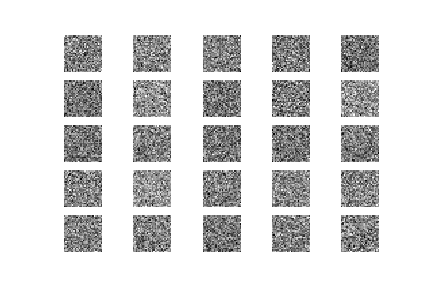

In [14]:
from IPython.display import display, Image
display(Image(filename='images/mnist_0.png'))

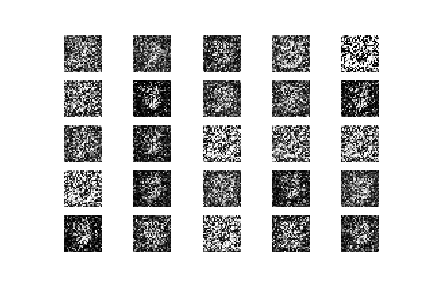

In [15]:
display(Image(filename='images/mnist_200.png'))

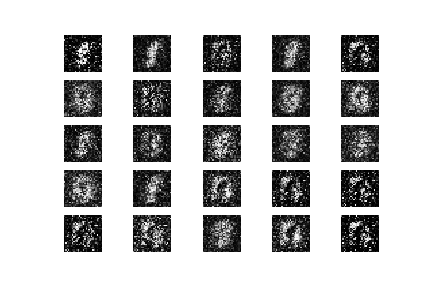

In [16]:
display(Image(filename='images/mnist_400.png'))

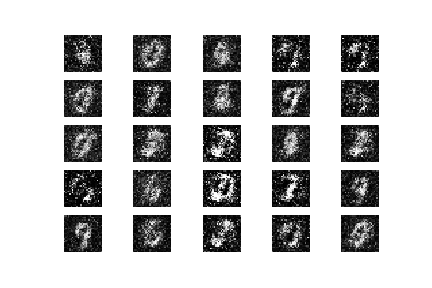

In [17]:
display(Image(filename='images/mnist_600.png'))

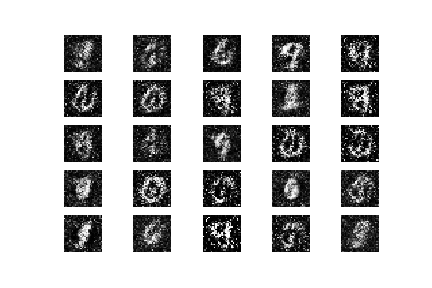

In [18]:
display(Image(filename='images/mnist_800.png'))

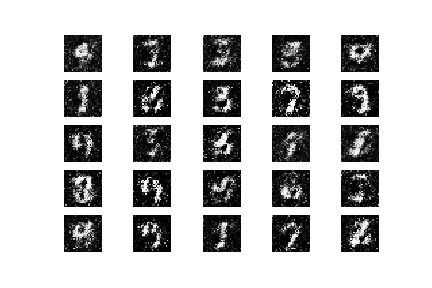

In [19]:
display(Image(filename='images/mnist_1000.png'))

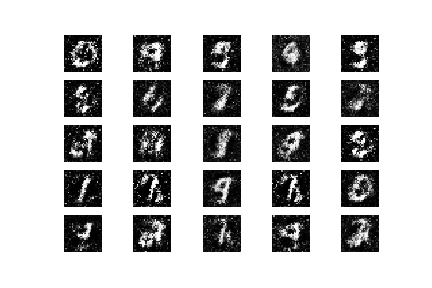

In [20]:
display(Image(filename='images/mnist_1200.png'))

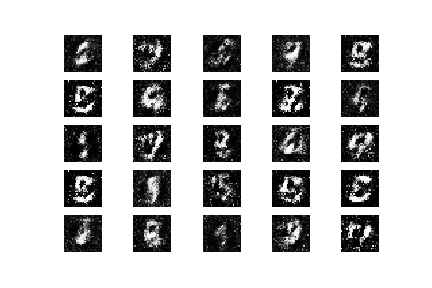

In [21]:
display(Image(filename='images/mnist_1400.png'))

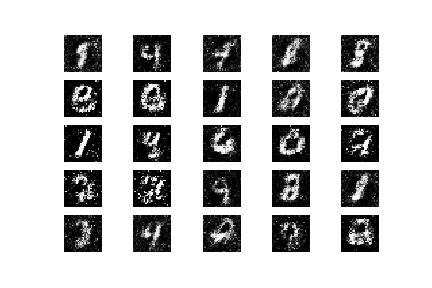

In [22]:
display(Image(filename='images/mnist_1600.png'))

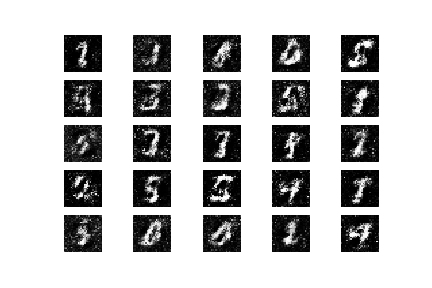

In [23]:
display(Image(filename='images/mnist_1800.png'))

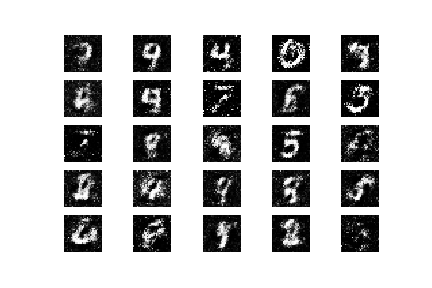

In [24]:
display(Image(filename='images/mnist_2000.png'))

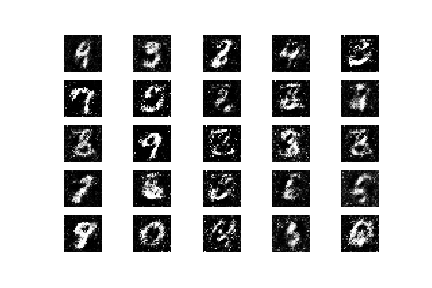

In [25]:
display(Image(filename='images/mnist_2200.png'))

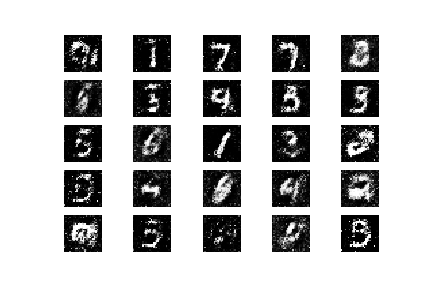

In [26]:
display(Image(filename='images/mnist_2400.png'))

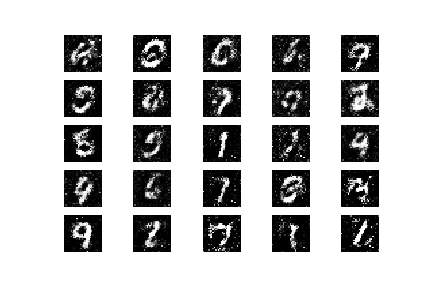

In [27]:
display(Image(filename='images/mnist_2600.png'))

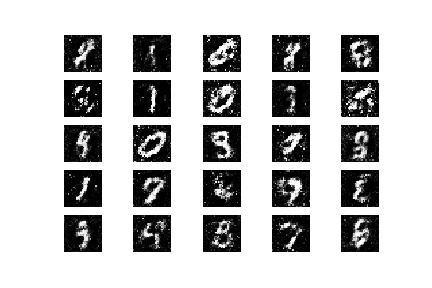

In [28]:
display(Image(filename='images/mnist_2800.png'))

In [50]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [29]:
noise_shape = (100,)

In [51]:
generator = Sequential()

In [52]:
generator.add(Dense(256,input_shape = noise_shape))

In [53]:
generator.add(LeakyReLU(alpha=0.2))

In [54]:
generator.add(BatchNormalization(momentum=0.8))

In [55]:
generator.add(Dense(512))

In [56]:
generator.add(LeakyReLU(alpha=0.2))

In [57]:
generator.add(BatchNormalization(momentum=0.8))

In [58]:
generator.add(Dense(1024))

In [59]:
generator.add(LeakyReLU(alpha=0.2))

In [60]:
generator.add(BatchNormalization(momentum=0.8))

In [61]:
generator.add(Dense(np.prod(img_shape), activation='tanh'))

In [62]:
generator.add(Reshape(img_shape))

In [63]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_34 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              525312    
__________

In [67]:
img = np.random.randn(1,100)

In [69]:
img_ger = generator.predict(img)

In [70]:
img_ger.shape

(1, 28, 28, 1)

In [71]:
img_ger[0]

array([[[ 2.19409302e-01],
        [-1.71771899e-01],
        [ 2.03477338e-01],
        [-2.86277443e-01],
        [ 1.27861220e-02],
        [ 2.39337981e-01],
        [-5.41047119e-02],
        [ 1.11748755e-01],
        [ 1.05585761e-01],
        [ 2.23450646e-01],
        [-7.81524405e-02],
        [-1.98621020e-01],
        [ 2.00685352e-01],
        [ 3.47226143e-01],
        [ 5.24543636e-02],
        [-1.51895061e-01],
        [ 9.66326147e-02],
        [ 5.87642603e-02],
        [-1.08047985e-01],
        [-1.44142672e-01],
        [ 1.59167215e-01],
        [-1.28850088e-01],
        [ 2.26981848e-01],
        [ 1.53533265e-01],
        [-4.40635443e-01],
        [-1.39485961e-02],
        [-1.69089362e-01],
        [ 8.26525167e-02]],

       [[ 4.47269902e-02],
        [ 2.78925207e-02],
        [ 1.13050481e-02],
        [-1.76402614e-01],
        [ 8.29711035e-02],
        [ 2.18353152e-01],
        [-1.41326264e-01],
        [-1.62059188e-01],
        [ 5.80587685e-02],

In [74]:
r, c = 5, 5
# Rescale images 0 - 1
gen_imgs = 0.5 * img_ger[0] + 0.5

fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
fig.savefig("images/mnist_%d.png" % epoch)
plt.close()

IndexError: too many indices for array

In [79]:
import matplotlib.pyplot as plt
plt.gray()

In [81]:
img_ger.shape

(1, 28, 28, 1)

In [83]:
img = np.reshape(img_ger,(28,28))

In [84]:
img.shape

(28, 28)

In [85]:
plt.imshow(img)

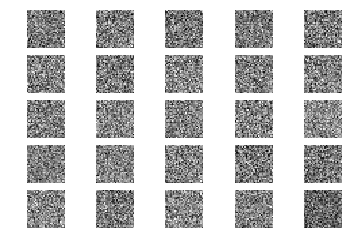

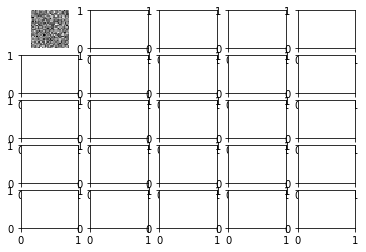

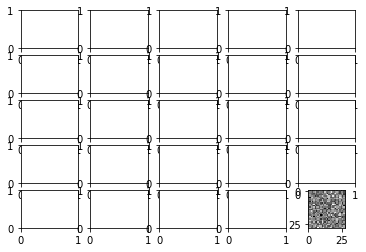

In [86]:
plt.show()

In [75]:
from PIL import Image
import numpy as np

w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)
data[256, 256] = [255, 0, 0]
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()

In [77]:
data.shape

(512, 512, 3)

In [78]:
img_ger[0].shape

(28, 28, 1)

In [ ]:
img = Image.fromarray(img_ger[0],)

In [87]:
from keras.datasets import mnist

In [88]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [89]:
 print(train_images.ndim)

3


In [90]:
 print(train_images.shape)

(60000, 28, 28)


In [92]:
print(train_images.dtype)

uint8


In [97]:
digit = train_images[1]

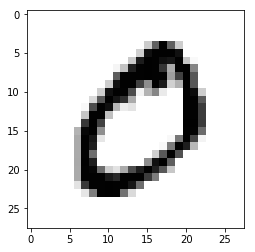

In [98]:
import matplotlib.pyplot as plt
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()